In [ ]:
from glob import glob
import os

from dask.distributed import LocalCluster
import pandas as pd
import pyarrow.dataset as pads
import pyarrow.csv as pcsv
import pyarrow.compute as pc

import numpy as np

In [ ]:
each_game = glob('../data/2024_SMT_Data_Challenge/game_info/**/*.csv', recursive=True)
#This can be changed depending on location of data

In [ ]:
each_game = [game.replace('game_info', '{}', 2)for game in each_game]

In [ ]:
def get_data_from_game(game_path, table_type, columns, filter=None):
    game_events_path = game_path.replace("{}", table_type, 2)
    game_events_table = pcsv.read_csv(game_events_path, convert_options=pcsv.ConvertOptions(
        include_columns=columns
    ))
    if filter is not None:
        return game_events_table.filter(filter).to_pandas()
    return game_events_table.to_pandas()

In [ ]:
def handle_game(game_path):
    pitches = get_data_from_game(
        game_path,
        "game_events",
        ['game_str', 'timestamp', 'play_per_game', 'event_code'],
        pc.field('event_code')==1
    )
    pitch_info_list = []
    for _, pitch in pitches.iterrows():
        pitch_info_list.append(
            handle_pitch(game_path, pitch)
        )
    return pitch_info_list

In [ ]:
def handle_pitch(game_path, pitch):
    pitcher_position_code = 1
    ball_pos_df = get_data_from_game(
        game_path,
        "ball_pos",
        ['ball_position_x', 'ball_position_y', 'ball_position_z', 'timestamp'],
        pc.field("timestamp")==pitch.timestamp
    )
    player_pos_df = get_data_from_game(
        game_path,
        "player_pos",
        ['field_x', 'field_y', 'timestamp', 'player_position'],
        ((pc.field("timestamp")==pitch.timestamp) & (pc.field("player_position")==pitcher_position_code))
    )
    game_info_df = get_data_from_game(
        game_path,
        "game_info",
        ['play_per_game', 'pitcher'],
        pc.field('play_per_game')==pitch.play_per_game
    )
    try:
        game_str = pitch.game_str
        timestamp = pitch.timestamp
        play_per_game = pitch.play_per_game
        x_ball_pos = ball_pos_df.iloc[0].ball_position_x
        y_ball_pos = ball_pos_df.iloc[0].ball_position_y
        z_ball_pos = ball_pos_df.iloc[0].ball_position_z
        x_pitcher_pos = player_pos_df.iloc[0].field_x
        y_pitcher_pos = player_pos_df.iloc[0].field_y
        pitcher_player_id = game_info_df.iloc[0].pitcher
    except IndexError:
        return {
        "game_str": np.nan,
        "timestamp": np.nan,
        "play_per_game": np.nan,
        "x_ball_pos": np.nan,
        "y_ball_pos": np.nan,
        "z_ball_pos": np.nan,
        "x_pitcher_pos": np.nan,
        "y_pitcher_pos": np.nan,
        "pitcher_player_id": np.nan
        }
    return {
        "game_str": game_str,
        "timestamp": timestamp,
        "play_per_game": play_per_game,
        "x_ball_pos": x_ball_pos,
        "y_ball_pos": y_ball_pos,
        "z_ball_pos": z_ball_pos,
        "x_pitcher_pos": x_pitcher_pos,
        "y_pitcher_pos": y_pitcher_pos,
        "pitcher_player_id": pitcher_player_id
    }

In [ ]:
from tqdm.notebook import tqdm
all_pitches = []
for game in tqdm(each_game):
    game_result = handle_game(game)
    for pitch in game_result:
        all_pitches.append(pitch)

  0%|          | 0/338 [00:00<?, ?it/s]

In [ ]:
df = pd.DataFrame(all_pitches)

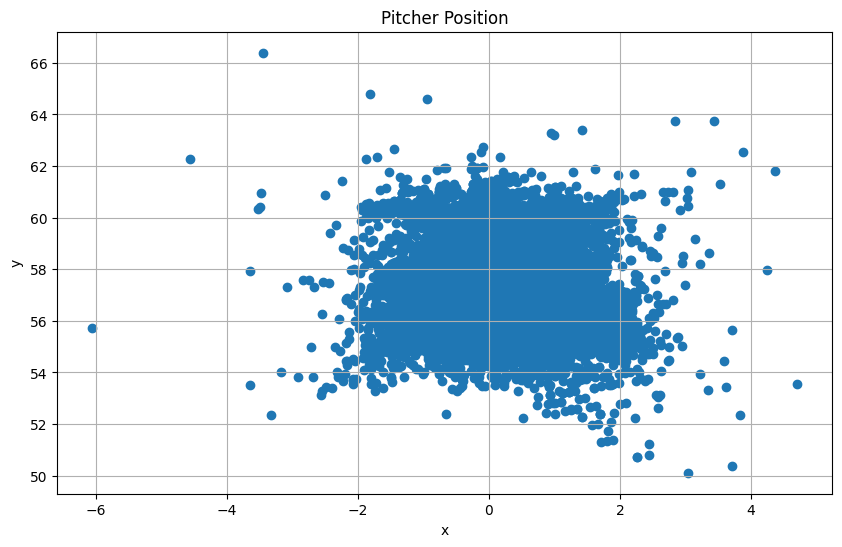

In [ ]:
import matplotlib.pyplot as plt

filter = df['y_pitcher_pos'] > 50

plt.figure(figsize=(10, 6))
plt.scatter(df.loc[filter]['x_pitcher_pos'], df.loc[filter]['y_pitcher_pos'], marker='o')
# plt.scatter(df['x_pitcher_pos'], df['y_pitcher_pos'], marker='o')
plt.title('Pitcher Position')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

filter_dropdown = widgets.Dropdown(
    options=df.pitcher_player_id.replace('\\N', np.nan).dropna().unique(),
    description='Filter:'
)

# Define the plotting function
def plot_data(filter_val):
    filtered_df = df[df['pitcher_player_id'] == filter_val]
    plt.figure(figsize=(10, 6))
    plt.scatter(filtered_df['x_pitcher_pos'], filtered_df['y_pitcher_pos'], marker='.', label="Pitcher Position")
    plt.scatter(filtered_df['x_ball_pos'], filtered_df['y_ball_pos'], marker='.', label="Ball Position")
    plt.title(f'Plot of pitcher and ball location (Pitcher Player ID = {filter_val})')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.legend()
    plt.show()

# Link the widgets to the plotting function
interactive_plot = widgets.interactive(plot_data, filter_val=filter_dropdown)

# display(filter_dropdown)
interactive_plot

interactive(children=(Dropdown(description='Filter:', options=(768.0, 2579.0, 645.0, 6366.0, 987.0, 5302.0, 94…

In [ ]:
df.pitcher_player_id.replace('\\N', np.nan).dropna().unique()

array([768.0, 2579.0, 645.0, ..., '7024', '7374', '3750'], dtype=object)

In [ ]:
df.pitcher_player_id.drop_duplicates()

0         768.0
7        2579.0
60          NaN
219       645.0
228      6366.0
          ...  
92556      2414
92741      6865
92786      7024
92851      7374
93015      3750
Name: pitcher_player_id, Length: 1015, dtype: object

In [ ]:
df.pitcher_player_id.value_counts()

pitcher_player_id
674.0     1187
722.0     1082
849.0      896
933.0      876
966.0      854
          ... 
664076       2
7913.0       1
6695.0       1
2534         1
2770.0       1
Name: count, Length: 1014, dtype: int64

In [ ]:
df['ball_dif'] = df.apply(lambda row: row.x_pitcher_pos - row.x_ball_pos, axis=1)

In [ ]:
pitcher_is_righty ={}
for pitcher in df.pitcher_player_id.replace('\\N', np.nan).dropna().unique():
    pitcher_is_righty[pitcher] = np.mean(df[df.pitcher_player_id == pitcher].ball_dif) > 0

In [ ]:
df['pitcher_is_righty'] = df.apply(lambda row: pitcher_is_righty[row.pitcher_player_id] if row.pitcher_player_id in pitcher_is_righty else None, axis=1)

In [ ]:
df.to_csv('Team106-results2-pitcher-location.csv', index=False)